## Импорты и данные

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")
%matplotlib inline

In [2]:
TRAIN_PATH = '../data/train.csv'
TEST_PATH = '../data/test.csv'
SUBMISSION_PATH = '../data/submission.csv'

In [3]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

## EDA

Вспомогательные функции

In [4]:
DATE_COLUMNS = ['Дата обращения', 'Крайний срок', 'Дата восстановления', 'Дата закрытия обращения']
def renaming(df: pd.DataFrame) -> pd.DataFrame:
    return df.rename(columns={'Решение             ': 'Решение'})

def look_on_column_values(train: pd.DataFrame, test: pd.DataFrame, column: str) -> None:
    train_unique_values = set(train[column].unique())
    test_unique_values = set(test[column].unique())
    union_unique_values = train_unique_values & test_unique_values

    print('Количество уникальных значений столбца ' + column + ' в train:', len(train_unique_values))
    print('Количество уникальных значений столбца ' + column + ' в test:', len(test_unique_values))
    print('Количество уникальных значений столбца ' + column + ' в пересечении train и test:', len(union_unique_values), '\n')
    
def change_date_types(df: pd.DataFrame) -> pd.DataFrame:
    for column in DATE_COLUMNS:
        df[column] = pd.to_datetime(df[column])
        
    return df

Окидываем сырые данные взглядом

In [5]:
train.head()

,Содержание,Сервис,Приоритет,Статус,Функциональная группа,Крайний срок,Дата обращения,Тип обращения на момент подачи,Тип обращения итоговый,Решение,Тип переклассификации,Дата восстановления,Дата закрытия обращения,Критичность,Влияние,Система,Место
0,Тест,АРМ,3-Низкий,Отменен,ФГ1,2018-01-24 07:42,2018-01-19 09:27,Запрос,Запрос,Тест,0,NaN,2018-01-19 09:43,4-Нет,3-Малое,База,К
1,Тестовое обращение,АРМ,3-Низкий,Отменен,ФГ1,2018-01-24 10:51,2018-01-19 09:36,Запрос,Запрос,Тест,0,NaN,2018-01-19 09:41,4-Нет,3-Малое,База,К
2,Выполнена разблокировка у/з REGION\*****,Сервис7,2-Средний,Закрыт,ФГ8,2018-01-31 07:51,2018-01-25 22:47,Запрос,Запрос,Выполнена разблокировка у/з Ne_bosS\*********\...,0,2018-01-25 22:47,2018-02-02 07:52,1-Особая,3-Малое,Система7,Место190
3,.Не включается ПК,АРМ,3-Низкий,Закрыт,ФГ390,2018-01-28 05:50,2018-01-25 23:13,Инцидент,Инцидент,Выход из стоя БП. Заменён.,0,2018-01-25 23:55,2018-01-26 00:00,4-Нет,3-Малое,База,Место177
4,"Заявка № ***********, *******************",АРМ,3-Низкий,Закрыт,ФГ303,2018-02-03 02:51,2018-01-25 23:39,Запрос,Запрос,Работы по обращению выполнены,0,2018-01-28 02:54,2018-02-04 07:53,4-Нет,4-Нет влияния,База,Место216


In [6]:
test.head()

,id,Содержание,Сервис,Приоритет,Статус,Функциональная группа,Крайний срок,Дата обращения,Тип обращения на момент подачи,Тип обращения итоговый,Решение,Тип переклассификации,Дата восстановления,Дата закрытия обращения,Критичность,Влияние,Система,Место
0,14803,Заявка на предоставление и отзыв прав доступа ...,Сервис41,3-Низкий,Закрыт,ФГ13,2018-02-22 07:51,2018-02-16 13:11,Запрос,NaN,Работы по обращению выполнены,NaN,2018-02-18 04:32,2018-02-25 07:56,4-Нет,4-Нет влияния,Система43,Место38
1,14804,Транспортный шлюз,Сервис61,2-Средний,Закрыт,ФГ1,2018-02-21 14:36,2018-02-16 13:13,Запрос,NaN,проинф у.о.,NaN,2018-02-16 17:55,2018-02-24 07:54,1-Особая,3-Малое,Система61,К
2,14805,Заявка на предоставление и отзыв прав доступа ...,Сервис22,3-Низкий,Закрыт,ФГ13,2018-03-31 06:36,2018-02-16 13:13,Запрос,NaN,Работы по обращению выполнены,NaN,2018-03-15 16:09,2018-03-23 07:56,2-Повышенная,4-Нет влияния,Система13,Место25
3,14806,Заявка на предоставление и отзыв прав доступа ...,Сервис91,3-Низкий,Отменен,ФГ13,2018-02-21 14:29,2018-02-16 13:14,Запрос,NaN,Запрос отменён пользователем из портала самооб...,NaN,2018-02-16 13:15,NaN,2-Повышенная,4-Нет влияния,Система363,Место1
4,14807,Заявка на предоставление и отзыв прав доступа ...,Сервис22,3-Низкий,Закрыт,ФГ13,2018-03-30 09:36,2018-02-16 13:14,Запрос,NaN,Работы по обращению выполнены,NaN,2018-03-15 16:09,2018-03-23 07:56,2-Повышенная,4-Нет влияния,Система13,Место25


In [7]:
train.shape, test.shape

((14803, 17), (6344, 18))

In [8]:
train = train.drop_duplicates()

In [9]:
train.shape, test.shape

((13284, 17), (6344, 18))

In [10]:
train = renaming(train)
test = renaming(test)

In [11]:
train = change_date_types(train)
test = change_date_types(test)

In [12]:
train.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13284 entries, 0 to 14802
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Содержание                      13283 non-null  object        
 1   Сервис                          13284 non-null  object        
 2   Приоритет                       13284 non-null  object        
 3   Статус                          13284 non-null  object        
 4   Функциональная группа           13284 non-null  object        
 5   Крайний срок                    13284 non-null  datetime64[ns]
 6   Дата обращения                  13284 non-null  datetime64[ns]
 7   Тип обращения на момент подачи  13284 non-null  object        
 8   Тип обращения итоговый          13284 non-null  object        
 9   Решение                         13284 non-null  object        
 10  Тип переклассификации           13284 non-null  int64         
 11  Да

In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6344 entries, 0 to 6343
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              6344 non-null   int64         
 1   Содержание                      6344 non-null   object        
 2   Сервис                          6344 non-null   object        
 3   Приоритет                       6344 non-null   object        
 4   Статус                          6344 non-null   object        
 5   Функциональная группа           6344 non-null   object        
 6   Крайний срок                    6344 non-null   datetime64[ns]
 7   Дата обращения                  6344 non-null   datetime64[ns]
 8   Тип обращения на момент подачи  6344 non-null   object        
 9   Тип обращения итоговый          0 non-null      float64       
 10  Решение                         6344 non-null   object        
 11  Тип 

Видим пропущенные значения -- посмотрим, от чего они, обработаем позже

In [14]:
train[train['Дата восстановления'].isnull()]['Статус'].value_counts()

Отменен    49
Name: Статус, dtype: int64

In [15]:
# заменим null в Дате восстановления на дату закрытия обращения, так как это все отмененные заявки 
test[test['Дата восстановления'].isnull()]['Статус'].value_counts()

Отменен    15
Name: Статус, dtype: int64

In [16]:
train[train['Дата закрытия обращения'].isnull()]['Статус'].value_counts()

Отменен    354
Name: Статус, dtype: int64

In [17]:
# заменим на Дату восстановленния
test[test['Дата закрытия обращения'].isnull()]['Статус'].value_counts()

Отменен    138
Name: Статус, dtype: int64

In [18]:
# можем сразу удалить
train[train['Содержание'].isnull()]

,Содержание,Сервис,Приоритет,Статус,Функциональная группа,Крайний срок,Дата обращения,Тип обращения на момент подачи,Тип обращения итоговый,Решение,Тип переклассификации,Дата восстановления,Дата закрытия обращения,Критичность,Влияние,Система,Место
4222,NaN,Сервис93,3-Низкий,Отменен,ФГ626,2018-02-02 07:06:00,2018-02-01 08:06:00,Инцидент,Инцидент,Зарегистрирован ошибочно.,0,NaT,2018-02-01 08:09:00,2-Повышенная,3-Малое,Система92,Место277


In [19]:
train.drop(index=[4222], inplace=True)

Посмотрим на уникальные значения признаков для теста и трейна

In [20]:
len(train['Содержание'].unique()), len(test['Содержание'].unique())

(1465, 738)

In [21]:
columns_to_look = ['Сервис', 'Приоритет', 'Статус', 'Функциональная группа', 'Тип обращения на момент подачи', 'Тип обращения итоговый',
                   'Тип переклассификации', 'Критичность', 'Влияние', 'Система', 'Место']

for column in columns_to_look:
    look_on_column_values(train, test, column)

Количество уникальных значений столбца Сервис в train: 153
Количество уникальных значений столбца Сервис в test: 120
Количество уникальных значений столбца Сервис в пересечении train и test: 96 

Количество уникальных значений столбца Приоритет в train: 4
Количество уникальных значений столбца Приоритет в test: 3
Количество уникальных значений столбца Приоритет в пересечении train и test: 3 

Количество уникальных значений столбца Статус в train: 2
Количество уникальных значений столбца Статус в test: 2
Количество уникальных значений столбца Статус в пересечении train и test: 2 

Количество уникальных значений столбца Функциональная группа в train: 554
Количество уникальных значений столбца Функциональная группа в test: 361
Количество уникальных значений столбца Функциональная группа в пересечении train и test: 322 

Количество уникальных значений столбца Тип обращения на момент подачи в train: 2
Количество уникальных значений столбца Тип обращения на момент подачи в test: 2
Количество

Смотрим, как соотносятся `('Тип обращения на момент подачи', 'Тип обращения итоговый')` с `'Тип переклассификации'`

In [22]:
train[['Тип обращения на момент подачи', 'Тип обращения итоговый', 'Тип переклассификации']].drop_duplicates()

,Тип обращения на момент подачи,Тип обращения итоговый,Тип переклассификации
0,Запрос,Запрос,0
3,Инцидент,Инцидент,0
917,Инцидент,Запрос,2
927,Запрос,Инцидент,1


Смотрим на баланс классов

In [23]:
train['Тип переклассификации'].value_counts()

0    12952
2      196
1      135
Name: Тип переклассификации, dtype: int64

Смотрим на значения признаков (у которых их не так много)

In [24]:
columns_not_variable = ['Приоритет', 'Статус', 'Тип обращения на момент подачи', 'Критичность', 'Влияние']

for column in columns_not_variable:
    print(column)
    display(train[column].value_counts())
    display(test[column].value_counts())

Приоритет


3-Низкий         8921
2-Средний        4348
1-Высокий          11
0-Критический       3
Name: Приоритет, dtype: int64

3-Низкий     4535
2-Средний    1805
1-Высокий       4
Name: Приоритет, dtype: int64

Статус


Закрыт     12877
Отменен      406
Name: Статус, dtype: int64

Закрыт     6189
Отменен     155
Name: Статус, dtype: int64

Тип обращения на момент подачи


Запрос      12837
Инцидент      446
Name: Тип обращения на момент подачи, dtype: int64

Запрос      5914
Инцидент     430
Name: Тип обращения на момент подачи, dtype: int64

Критичность


4-Нет           5975
1-Особая        4370
2-Повышенная    2063
3-Базовая        875
Name: Критичность, dtype: int64

4-Нет           2555
1-Особая        1813
2-Повышенная    1496
3-Базовая        480
Name: Критичность, dtype: int64

Влияние


4-Нет влияния        8465
3-Малое              4760
2-Значительное         53
1-Всеохватывающее       5
Name: Влияние, dtype: int64

4-Нет влияния        4034
3-Малое              2279
2-Значительное         29
1-Всеохватывающее       2
Name: Влияние, dtype: int64

Посмотрим на то же самое, но на картинках

/Users/elena/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


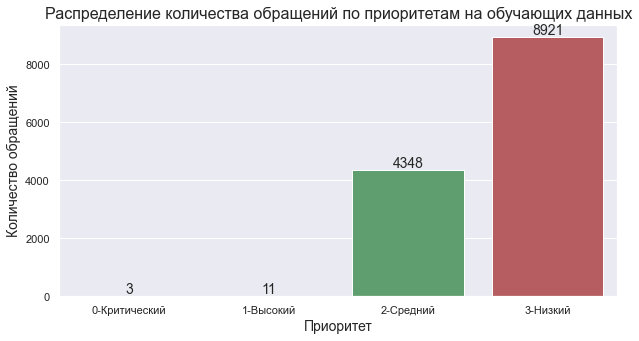

In [25]:
plt.figure(figsize=(10,5))

ax = sns.countplot(train['Приоритет'].sort_values())

abs_values = train['Приоритет'].value_counts().sort_index().values
ax.bar_label(container=ax.containers[0], labels=abs_values, fontsize=14)

plt.xlabel('Приоритет', fontsize=14)
plt.ylabel('Количество обращений', fontsize=14)
plt.title('Распределение количества обращений по приоритетам на обучающих данных', fontsize=16)

plt.show()

/Users/elena/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


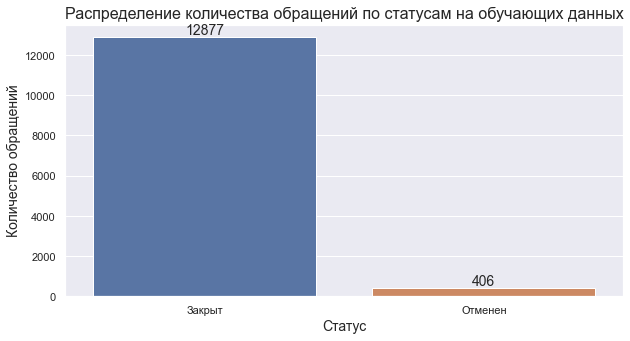

In [26]:
plt.figure(figsize=(10,5))

ax = sns.countplot(train['Статус'].sort_values())

abs_values = train['Статус'].value_counts().sort_index().values
ax.bar_label(container=ax.containers[0], labels=abs_values, fontsize=14)

plt.xlabel('Статус', fontsize=14)
plt.ylabel('Количество обращений', fontsize=14)
plt.title('Распределение количества обращений по статусам на обучающих данных', fontsize=16)

plt.show()

/Users/elena/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


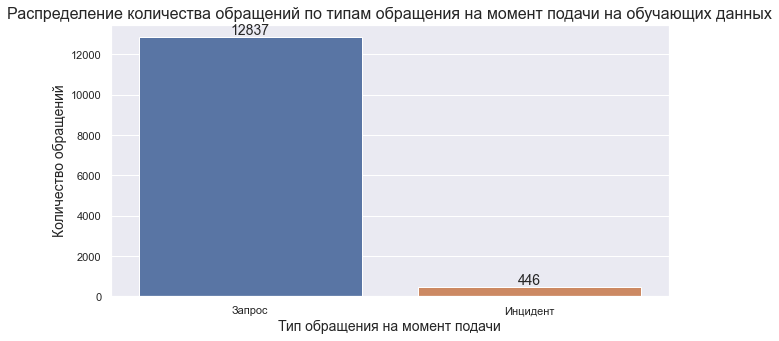

In [27]:
plt.figure(figsize=(10,5))

ax = sns.countplot(train['Тип обращения на момент подачи'].sort_values())

abs_values = train['Тип обращения на момент подачи'].value_counts().sort_index().values
ax.bar_label(container=ax.containers[0], labels=abs_values, fontsize=14)

plt.xlabel('Тип обращения на момент подачи', fontsize=14)
plt.ylabel('Количество обращений', fontsize=14)
plt.title('Распределение количества обращений по типам обращения на момент подачи на обучающих данных', fontsize=16)

plt.show()

/Users/elena/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


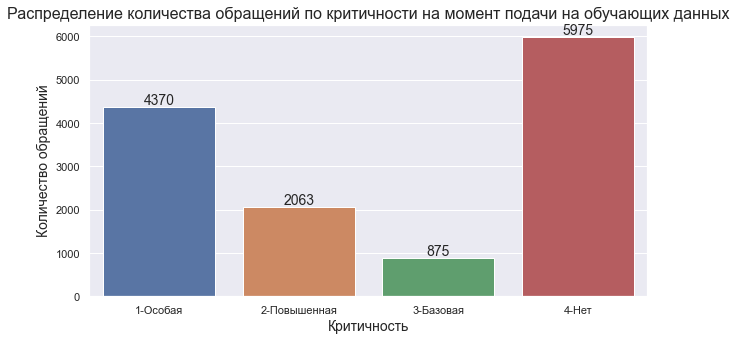

In [28]:
plt.figure(figsize=(10,5))

ax = sns.countplot(train['Критичность'].sort_values())

abs_values = train['Критичность'].value_counts().sort_index().values
ax.bar_label(container=ax.containers[0], labels=abs_values, fontsize=14)

plt.xlabel('Критичность', fontsize=14)
plt.ylabel('Количество обращений', fontsize=14)
plt.title('Распределение количества обращений по критичности на момент подачи на обучающих данных', fontsize=16)

plt.show()

/Users/elena/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


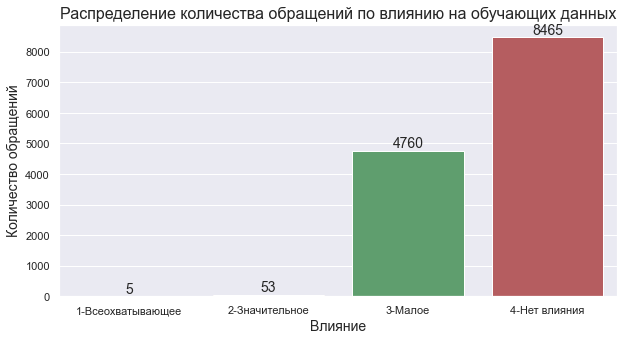

In [29]:
plt.figure(figsize=(10,5))

ax = sns.countplot(train['Влияние'].sort_values())

abs_values = train['Влияние'].value_counts().sort_index().values
ax.bar_label(container=ax.containers[0], labels=abs_values, fontsize=14)

plt.xlabel('Влияние', fontsize=14)
plt.ylabel('Количество обращений', fontsize=14)
plt.title('Распределение количества обращений по влиянию на обучающих данных', fontsize=16)

plt.show()

Посмотрим на данные с датами

In [30]:
train['Дата обращения'].min(), train['Дата обращения'].max()

(Timestamp('2018-01-19 09:27:00'), Timestamp('2018-02-16 13:10:00'))

In [31]:
train['Крайний срок'].min(), train['Крайний срок'].max()

(Timestamp('2017-03-08 11:36:00'), Timestamp('2018-08-26 07:12:00'))

In [32]:
train['Дата восстановления'].min(), train['Дата восстановления'].max()

(Timestamp('2018-01-25 22:47:00'), Timestamp('2018-06-08 13:03:00'))

In [33]:
train['Дата закрытия обращения'].min(), train['Дата закрытия обращения'].max()

(Timestamp('2018-01-19 09:41:00'), Timestamp('2018-06-09 08:18:00'))

In [34]:
test['Дата обращения'].min(), test['Дата обращения'].max()

(Timestamp('2018-02-16 13:11:00'), Timestamp('2018-02-25 21:35:00'))

In [35]:
test['Крайний срок'].min(), test['Крайний срок'].max()

(Timestamp('2017-03-10 17:36:00'), Timestamp('2019-02-10 12:55:00'))

In [36]:
test['Дата восстановления'].min(), test['Дата восстановления'].max()

(Timestamp('2018-02-16 13:15:00'), Timestamp('2018-05-27 10:41:00'))

In [37]:
test['Дата закрытия обращения'].min(), test['Дата закрытия обращения'].max()

(Timestamp('2018-02-16 13:42:00'), Timestamp('2018-05-13 09:47:00'))

Есть данные, где `Крайний срок` раньше, чем `Дата обращения`

In [38]:
train[train['Крайний срок'] < train['Дата обращения']]

,Содержание,Сервис,Приоритет,Статус,Функциональная группа,Крайний срок,Дата обращения,Тип обращения на момент подачи,Тип обращения итоговый,Решение,Тип переклассификации,Дата восстановления,Дата закрытия обращения,Критичность,Влияние,Система,Место
4119,36 заявка,АРМ,3-Низкий,Отменен,ФГ250,2017-03-08 11:36:00,2018-02-01 06:46:00,Запрос,Запрос,Запрос отменён пользователем из портала самооб...,0,2018-02-02 09:37:00,NaT,4-Нет,3-Малое,База,Место163


In [39]:
test[test['Крайний срок'] < test['Дата обращения']]

,id,Содержание,Сервис,Приоритет,Статус,Функциональная группа,Крайний срок,Дата обращения,Тип обращения на момент подачи,Тип обращения итоговый,Решение,Тип переклассификации,Дата восстановления,Дата закрытия обращения,Критичность,Влияние,Система,Место
4207,19010,Заявка на управление доступом к коммуникационн...,АРМ,3-Низкий,Отменен,ФГ569,2017-03-12 13:36:00,2018-02-23 08:13:00,Запрос,NaN,Запрос отменён пользователем из портала самооб...,NaN,2018-03-10 13:45:00,NaT,4-Нет,3-Малое,База,Место150
5053,19856,Интранет-портал: технические вопросы,Сервис65,3-Низкий,Отменен,ФГ520,2017-03-10 17:36:00,2018-02-24 08:36:00,Запрос,NaN,Запрос отменён пользователем из портала самооб...,NaN,2018-02-25 12:45:00,NaT,2-Повышенная,4-Нет влияния,Система105,Место26


Так как такие данные есть и в тесте, то оставим, тем более они отмененные

In [40]:
# отменен - однозначно 0
train[train['Статус'] == 'Отменен']['Тип переклассификации'].value_counts()

0    406
Name: Тип переклассификации, dtype: int64

Создадим словарь с ранговыми признаками, объединив их

In [41]:
ranks = train[['Приоритет', 'Критичность', 'Влияние']].drop_duplicates().sort_values(by=['Приоритет', 'Критичность', 'Влияние'], ascending=False)
rank_dict = ranks.reset_index().drop(columns='index').reset_index().set_index('index').T.to_dict('list')

In [42]:
ranks.reset_index().drop(columns='index').reset_index().rename(columns={'index': 'Ранг важности'})

,Ранг важности,Приоритет,Критичность,Влияние
0,0,3-Низкий,4-Нет,4-Нет влияния
1,1,3-Низкий,4-Нет,3-Малое
2,2,3-Низкий,4-Нет,2-Значительное
3,3,3-Низкий,4-Нет,1-Всеохватывающее
4,4,3-Низкий,3-Базовая,4-Нет влияния
5,5,3-Низкий,3-Базовая,3-Малое
6,6,3-Низкий,3-Базовая,2-Значительное
7,7,3-Низкий,2-Повышенная,4-Нет влияния
8,8,3-Низкий,2-Повышенная,3-Малое
9,9,3-Низкий,1-Особая,4-Нет влияния


## Подготовка датасета (не-текстовые данные)

Подготовим обучающие и тестовые данные -- проработаем пропущенные значения, сгенерируем новые признаки, обработаем категориальные и удалим ненужные. Сохраним обработанные данные

In [43]:
SECS_IN_DAY = 86400
DICT_STATUS = {'Отменен': 0, 'Закрыт': 1}
DICT_DAY_WEEK = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4,
                 'Saturday': 5, 'Sunday': 6}
DICT_TYPE = {'Инцидент': 0, 'Запрос': 1}
    
def fill_nans(df: pd.DataFrame) -> pd.DataFrame:
    df['Дата восстановления'] = df['Дата восстановления'].fillna(df['Дата закрытия обращения'])
    df['Дата закрытия обращения'] = df['Дата закрытия обращения'].fillna(df['Дата восстановления'])
    
    return df
    
def make_total_rank_feature(df: pd.DataFrame, rank_dict: dict) -> pd.DataFrame:
    df['Ранг важности'] = 0
    for key in rank_dict.keys():
        df.loc[(df['Приоритет'] == rank_dict[key][0]) & (df['Критичность'] == rank_dict[key][1]) & (df['Влияние'] == rank_dict[key][2]), 'Ранг важности'] = key
    
    df.drop(columns=['Приоритет', 'Критичность', 'Влияние'], inplace=True)
    
    return df

def take_seconds(time: pd.Timedelta) -> int:
    days = time.days
    seconds = time.seconds
    
    total_seconds = days * SECS_IN_DAY + seconds
    
    return total_seconds

def make_new_date_features(df: pd.DataFrame) -> pd.DataFrame:
    df['День недели обращения'] = df['Дата обращения'].dt.strftime('%A')
    df['Месяц обращения'] = df['Дата обращения'].dt.month
    df['Час обращения'] = df['Дата обращения'].dt.hour
    df['День года обращения'] = df['Дата обращения'].dt.strftime('%j').astype(int)
    
    return df

def make_features_with_seconds(df: pd.DataFrame) -> pd.DataFrame:
    df['Время с обращения до восстановления'] = (df['Дата восстановления'] - df['Дата обращения']).apply(take_seconds)
    df['Время с обращения до закрытия'] = (df['Дата закрытия обращения'] - df['Дата обращения']).apply(take_seconds)
    df['Время с обращения до крайнего срока'] = (df['Крайний срок'] - df['Дата обращения']).apply(take_seconds)
    df['Время с восстановления до крайнего срока'] = (df['Крайний срок'] - df['Дата восстановления']).apply(take_seconds)
    df['Время с закрытия до крайнего срока'] = (df['Крайний срок'] - df['Дата закрытия обращения']).apply(take_seconds)
    
    return df

def format_service(service: str) -> int:
    if service == 'АРМ':
        return 0
    else:
        return int(service[6:])
    
def format_func_group(group: str) -> int:
    if group[:2] == 'ФГ' and group[2].isdigit():
        return int(group[2:])
    elif group[:2] == 'СВ'  and group[2].isdigit():
        return int(group[2:]) + 1000
    else:
        return 2000
    
def format_system(system: str) -> int:
    if system == 'База':
        return 0
    elif system[7].isdigit():
        return int(system[7:])
    else:
        return 1000
    
def format_place(place: str) -> int:
    if place == 'К':
        return 1001
    elif place == 'Н':
        return 1002
    elif place == '#Н/Д':
        return 1003
    elif place[5].isdigit():
        return int(place[5:])
    else:
        return 1000

def format_categ_features(df: pd.DataFrame) -> pd.DataFrame:
    df['Сервис'] = df['Сервис'].apply(format_service)
    df['Функциональная группа'] = df['Функциональная группа'].apply(format_func_group)
    df['Система'] = df['Система'].apply(format_system)
    df['Место'] = df['Место'].apply(format_place)
    
    df['Статус'] = df['Статус'].map(DICT_STATUS)
    df['День недели обращения'] = df['День недели обращения'].map(DICT_DAY_WEEK)
    df['Тип обращения на момент подачи'] = df['Тип обращения на момент подачи'].map(DICT_TYPE)
    df['Тип обращения итоговый'] = df['Тип обращения итоговый'].map(DICT_TYPE)
    
    return df

def preprocess_not_text_features_and_make_new_features(df: pd.DataFrame, rank_dict: dict, file_path: str) -> pd.DataFrame:
    df = fill_nans(df)
    df = make_total_rank_feature(df, rank_dict)
    df = make_new_date_features(df)
    df = make_features_with_seconds(df)
    df = format_categ_features(df)
    
    display(df.info())
    display(df.head())
    
    df.to_csv(file_path, index=False)
    
    return df

In [44]:
train = preprocess_not_text_features_and_make_new_features(train, rank_dict, '../data/preprocessed_wo_text_train.csv')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13283 entries, 0 to 14802
Data columns (total 24 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   Содержание                                13283 non-null  object        
 1   Сервис                                    13283 non-null  int64         
 2   Статус                                    13283 non-null  int64         
 3   Функциональная группа                     13283 non-null  int64         
 4   Крайний срок                              13283 non-null  datetime64[ns]
 5   Дата обращения                            13283 non-null  datetime64[ns]
 6   Тип обращения на момент подачи            13283 non-null  int64         
 7   Тип обращения итоговый                    13283 non-null  int64         
 8   Решение                                   13283 non-null  object        
 9   Тип переклассификации       

None

,Содержание,Сервис,Статус,Функциональная группа,Крайний срок,Дата обращения,Тип обращения на момент подачи,Тип обращения итоговый,Решение,Тип переклассификации,...,Ранг важности,День недели обращения,Месяц обращения,Час обращения,День года обращения,Время с обращения до восстановления,Время с обращения до закрытия,Время с обращения до крайнего срока,Время с восстановления до крайнего срока,Время с закрытия до крайнего срока
0,Тест,0,0,1,2018-01-24 07:42:00,2018-01-19 09:27:00,1,1,Тест,0,...,1,4,1,9,19,960,960,425700,424740,424740
1,Тестовое обращение,0,0,1,2018-01-24 10:51:00,2018-01-19 09:36:00,1,1,Тест,0,...,1,4,1,9,19,300,300,436500,436200,436200
2,Выполнена разблокировка у/з REGION\*****,7,1,8,2018-01-31 07:51:00,2018-01-25 22:47:00,1,1,Выполнена разблокировка у/з Ne_bosS\*********\...,0,...,12,3,1,22,25,0,637500,464640,464640,-172860
3,.Не включается ПК,0,1,390,2018-01-28 05:50:00,2018-01-25 23:13:00,0,0,Выход из стоя БП. Заменён.,0,...,1,3,1,23,25,2520,2820,196620,194100,193800
4,"Заявка № ***********, *******************",0,1,303,2018-02-03 02:51:00,2018-01-25 23:39:00,1,1,Работы по обращению выполнены,0,...,0,3,1,23,25,184500,807240,702720,518220,-104520


In [45]:
test = preprocess_not_text_features_and_make_new_features(test, rank_dict, '../data/preprocessed_wo_text_test.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6344 entries, 0 to 6343
Data columns (total 25 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   id                                        6344 non-null   int64         
 1   Содержание                                6344 non-null   object        
 2   Сервис                                    6344 non-null   int64         
 3   Статус                                    6344 non-null   int64         
 4   Функциональная группа                     6344 non-null   int64         
 5   Крайний срок                              6344 non-null   datetime64[ns]
 6   Дата обращения                            6344 non-null   datetime64[ns]
 7   Тип обращения на момент подачи            6344 non-null   int64         
 8   Тип обращения итоговый                    0 non-null      float64       
 9   Решение                       

None

,id,Содержание,Сервис,Статус,Функциональная группа,Крайний срок,Дата обращения,Тип обращения на момент подачи,Тип обращения итоговый,Решение,...,Ранг важности,День недели обращения,Месяц обращения,Час обращения,День года обращения,Время с обращения до восстановления,Время с обращения до закрытия,Время с обращения до крайнего срока,Время с восстановления до крайнего срока,Время с закрытия до крайнего срока
0,14803,Заявка на предоставление и отзыв прав доступа ...,41,1,13,2018-02-22 07:51:00,2018-02-16 13:11:00,1,NaN,Работы по обращению выполнены,...,0,4,2,13,47,141660,758700,499200,357540,-259500
1,14804,Транспортный шлюз,61,1,1,2018-02-21 14:36:00,2018-02-16 13:13:00,1,NaN,проинф у.о.,...,12,4,2,13,47,16920,672060,436980,420060,-235080
2,14805,Заявка на предоставление и отзыв прав доступа ...,22,1,13,2018-03-31 06:36:00,2018-02-16 13:13:00,1,NaN,Работы по обращению выполнены,...,7,4,2,13,47,2343360,3004980,3691380,1348020,686400
3,14806,Заявка на предоставление и отзыв прав доступа ...,91,0,13,2018-02-21 14:29:00,2018-02-16 13:14:00,1,NaN,Запрос отменён пользователем из портала самооб...,...,7,4,2,13,47,60,60,436500,436440,436440
4,14807,Заявка на предоставление и отзыв прав доступа ...,22,1,13,2018-03-30 09:36:00,2018-02-16 13:14:00,1,NaN,Работы по обращению выполнены,...,7,4,2,13,47,2343300,3004920,3615720,1272420,610800


## Рисуночки

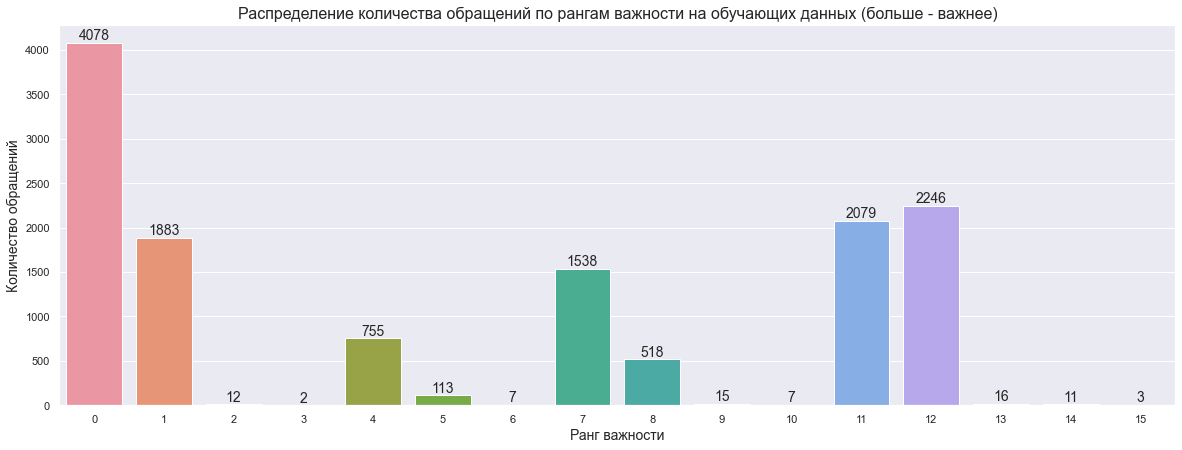

In [46]:
plt.figure(figsize=(20,7))

ax = sns.countplot(data=train, x='Ранг важности')

abs_values = train['Ранг важности'].value_counts().sort_index().values
ax.bar_label(container=ax.containers[0], labels=abs_values, fontsize=14)

plt.xlabel('Ранг важности', fontsize=14)
plt.ylabel('Количество обращений', fontsize=14)
plt.title('Распределение количества обращений по рангам важности на обучающих данных (больше - важнее)', fontsize=16)

plt.show()

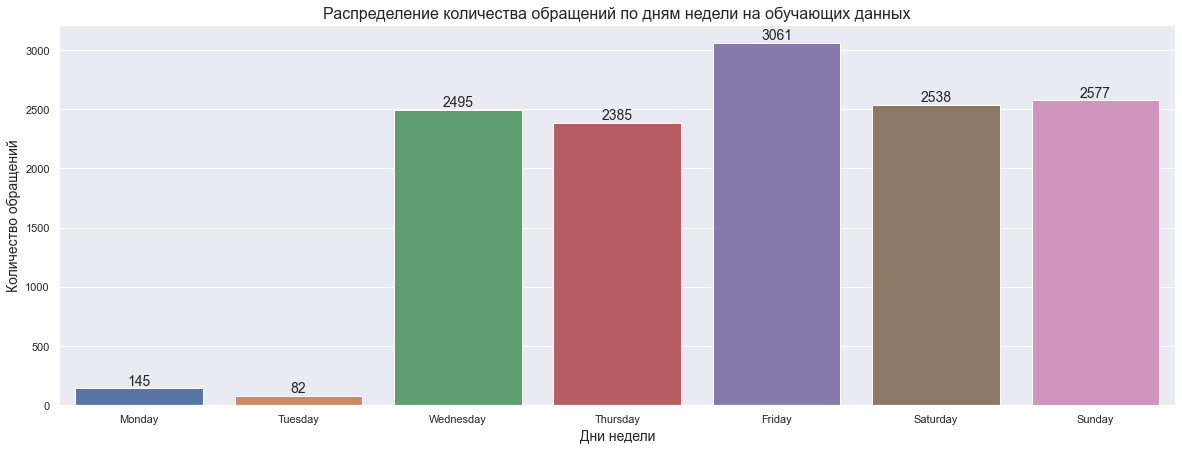

In [47]:
plt.figure(figsize=(20,7))

ax = sns.countplot(data=train, x='День недели обращения')

abs_values = train['День недели обращения'].value_counts().sort_index().values
ax.bar_label(container=ax.containers[0], labels=abs_values, fontsize=14)

plt.xlabel('Дни недели', fontsize=14)
plt.ylabel('Количество обращений', fontsize=14)
plt.title('Распределение количества обращений по дням недели на обучающих данных', fontsize=16)
plt.xticks(ticks=[i for i in range(7)],
           labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.show()

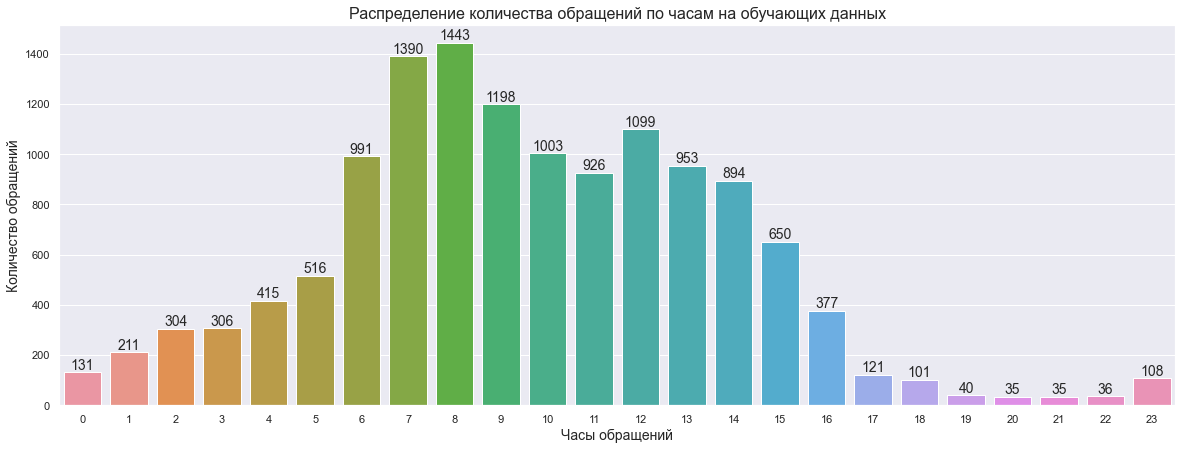

In [48]:
plt.figure(figsize=(20,7))

ax = sns.countplot(data=train, x='Час обращения')

abs_values = train['Час обращения'].value_counts().sort_index().values
ax.bar_label(container=ax.containers[0], labels=abs_values, fontsize=14)

plt.xlabel('Часы обращений', fontsize=14)
plt.ylabel('Количество обращений', fontsize=14)
plt.title('Распределение количества обращений по часам на обучающих данных', fontsize=16)

plt.show()

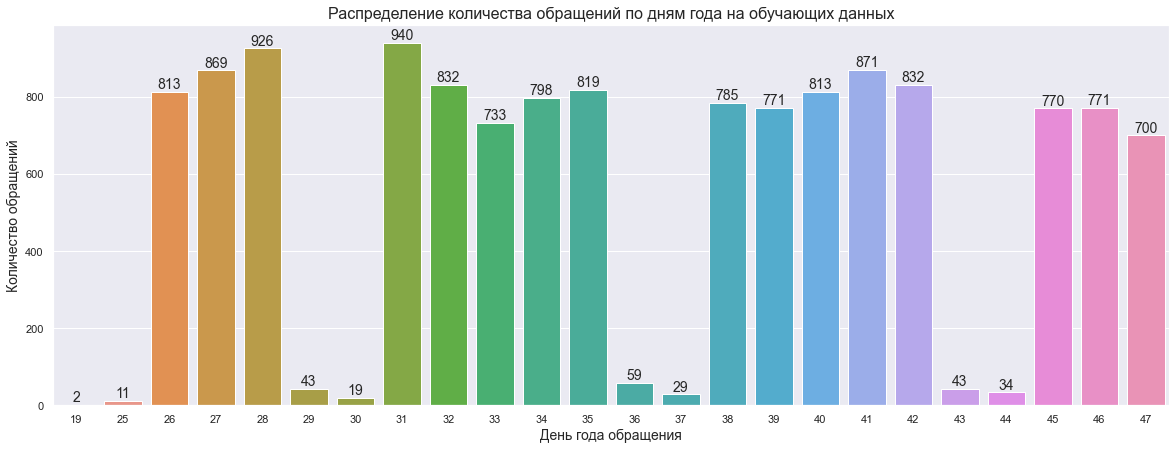

In [49]:
plt.figure(figsize=(20,7))

ax = sns.countplot(data=train, x='День года обращения')

abs_values = train['День года обращения'].value_counts().sort_index().values
ax.bar_label(container=ax.containers[0], labels=abs_values, fontsize=14)

plt.xlabel('День года обращения', fontsize=14)
plt.ylabel('Количество обращений', fontsize=14)
plt.title('Распределение количества обращений по дням года на обучающих данных', fontsize=16)

plt.show()

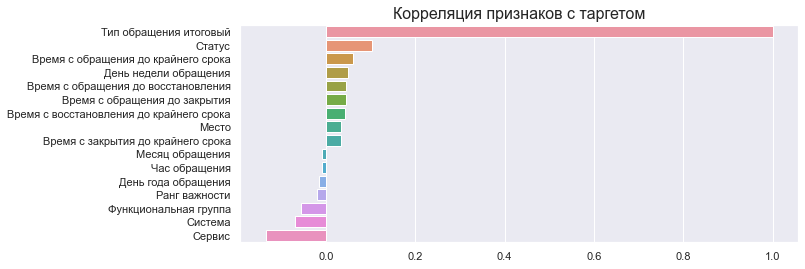

In [50]:
train_corr = train[['Сервис', 'Статус', 'Функциональная группа',  'Тип обращения итоговый',
       'Система', 'Место', 'Ранг важности', 'Время с обращения до восстановления',
       'Время с обращения до закрытия', 'Время с обращения до крайнего срока',
       'Время с восстановления до крайнего срока',
       'Время с закрытия до крайнего срока', 'День недели обращения',
       'Месяц обращения', 'Час обращения',
       'День года обращения']]

correlations = train_corr.corrwith(train_corr['Тип обращения итоговый']).sort_values(ascending=False)

plot = sns.barplot(y=correlations.index, x=correlations)
plot.figure.set_size_inches(10, 4)
plt.title('Корреляция признаков с таргетом', fontsize=16)

plt.show()

## Подготовка датасета (текстовые данные)

В текстовых данных делаем нижний регистр, удаляем знаки препинания и стоп-слова. Сохраняем все

In [51]:
import re
import nltk
import string
from nltk.corpus import stopwords
from pymystem3 import Mystem

nltk.download('stopwords')

def lowercasing(text: str) -> str:
    return text.lower()

def delete_punctuation(text: str) -> str:
    return re.sub(r'[^\w\s]','', text) 

def lemmatization(text: str) -> str:
    mystem_analyzer = Mystem()
    lemmas = mystem_analyzer.lemmatize(text)
    new_text = ' '.join(lemmas)

    return new_text

def delete_stopwords(text: str) -> str:
    russian_stopwords = stopwords.words("russian")
    split_text = text.split()
    new_split_text = [word for word in split_text if word not in russian_stopwords]
    new_text = ' '.join(new_split_text)

    return new_text

def preprocess_text_features(df: pd.DataFrame, file_path: str) -> pd.DataFrame:
    text_features = ['Содержание', 'Решение']
    
    for feature in text_features:
        df[feature] = df[feature].apply(lowercasing)
        df[feature] = df[feature].apply(delete_punctuation)
        #df[feature] = df[feature].apply(lemmatization) # долго
        df[feature] = df[feature].apply(delete_stopwords)
        
    df.to_csv(file_path, index=False)
    
    return df

[nltk_data] Downloading package stopwords to /Users/elena/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [52]:
train = preprocess_text_features(train, '../data/preprocessed_train.csv')

In [53]:
test = preprocess_text_features(test, '../data/preprocessed_test.csv')

In [54]:
train.head()

,Содержание,Сервис,Статус,Функциональная группа,Крайний срок,Дата обращения,Тип обращения на момент подачи,Тип обращения итоговый,Решение,Тип переклассификации,...,Ранг важности,День недели обращения,Месяц обращения,Час обращения,День года обращения,Время с обращения до восстановления,Время с обращения до закрытия,Время с обращения до крайнего срока,Время с восстановления до крайнего срока,Время с закрытия до крайнего срока
0,тест,0,0,1,2018-01-24 07:42:00,2018-01-19 09:27:00,1,1,тест,0,...,1,4,1,9,19,960,960,425700,424740,424740
1,тестовое обращение,0,0,1,2018-01-24 10:51:00,2018-01-19 09:36:00,1,1,тест,0,...,1,4,1,9,19,300,300,436500,436200,436200
2,выполнена разблокировка уз region,7,1,8,2018-01-31 07:51:00,2018-01-25 22:47:00,1,1,выполнена разблокировка уз ne_boss идентификац...,0,...,12,3,1,22,25,0,637500,464640,464640,-172860
3,включается пк,0,1,390,2018-01-28 05:50:00,2018-01-25 23:13:00,0,0,выход стоя бп заменён,0,...,1,3,1,23,25,2520,2820,196620,194100,193800
4,заявка,0,1,303,2018-02-03 02:51:00,2018-01-25 23:39:00,1,1,работы обращению выполнены,0,...,0,3,1,23,25,184500,807240,702720,518220,-104520


In [55]:
test.head()

,id,Содержание,Сервис,Статус,Функциональная группа,Крайний срок,Дата обращения,Тип обращения на момент подачи,Тип обращения итоговый,Решение,...,Ранг важности,День недели обращения,Месяц обращения,Час обращения,День года обращения,Время с обращения до восстановления,Время с обращения до закрытия,Время с обращения до крайнего срока,Время с восстановления до крайнего срока,Время с закрытия до крайнего срока
0,14803,заявка предоставление отзыв прав доступа ресурсам,41,1,13,2018-02-22 07:51:00,2018-02-16 13:11:00,1,NaN,работы обращению выполнены,...,0,4,2,13,47,141660,758700,499200,357540,-259500
1,14804,транспортный шлюз,61,1,1,2018-02-21 14:36:00,2018-02-16 13:13:00,1,NaN,проинф уо,...,12,4,2,13,47,16920,672060,436980,420060,-235080
2,14805,заявка предоставление отзыв прав доступа ресурсам,22,1,13,2018-03-31 06:36:00,2018-02-16 13:13:00,1,NaN,работы обращению выполнены,...,7,4,2,13,47,2343360,3004980,3691380,1348020,686400
3,14806,заявка предоставление отзыв прав доступа ресурсам,91,0,13,2018-02-21 14:29:00,2018-02-16 13:14:00,1,NaN,запрос отменён пользователем портала самообслу...,...,7,4,2,13,47,60,60,436500,436440,436440
4,14807,заявка предоставление отзыв прав доступа ресурсам,22,1,13,2018-03-30 09:36:00,2018-02-16 13:14:00,1,NaN,работы обращению выполнены,...,7,4,2,13,47,2343300,3004920,3615720,1272420,610800
